# Project 1: Retinal Vessel Segmentation with Bi-Level Class Balancing

## Objective:
- Apply preprocessing (GCN, CLAHE, gamma correction)
- Implement Bi-Level Balancing for vessel and non-vessel segmentation
- Train CNN on DRIVE dataset and evaluate with AUC, sensitivity, specificity


In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.utils import to_categorical


In [2]:
# Cell 2: Data Loader

import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256)):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    X = []
    y = []
    for img_file, mask_file in zip(image_files, mask_files):
        img = load_img(os.path.join(image_dir, img_file), target_size=img_size)
        mask = load_img(os.path.join(mask_dir, mask_file), target_size=img_size, color_mode="grayscale")
        X.append(img_to_array(img) / 255.0)
        y.append(img_to_array(mask) / 255.0)
    return np.array(X), np.array(y)


In [3]:
# Cell 3: U-Net Model
def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    u1 = UpSampling2D((2, 2))(c3)
    concat1 = concatenate([u1, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)

    u2 = UpSampling2D((2, 2))(c4)
    concat2 = concatenate([u2, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(concat2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


Image shape: (28, 256, 256, 3)
Mask shape: (28, 256, 256, 1)
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7529 - loss: 0.6844 - val_accuracy: 0.9075 - val_loss: 0.6472
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step - accuracy: 0.9101 - loss: 0.6513 - val_accuracy: 0.9298 - val_loss: 0.6257
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 0.9289 - loss: 0.6316 - val_accuracy: 0.9298 - val_loss: 0.6044
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step - accuracy: 0.9289 - loss: 0.6117 - val_accuracy: 0.9298 - val_loss: 0.5800
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - accuracy: 0.9289 - loss: 0.5886 - val_accuracy: 0.9298 - val_loss: 0.5501


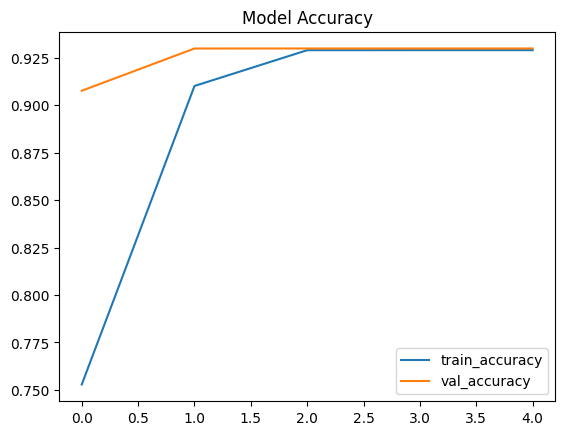

In [4]:
# Cell 4: Train and Evaluate
from sklearn.model_selection import train_test_split
image_dir = r'C:\Users\KIIT\data science\archive (2)\CHASE_DB1\Images'  # Replace with your image directory
mask_dir = r'C:\Users\KIIT\data science\archive (2)\CHASE_DB1\Masks'  # Replace with your mask directory

X, y = load_images_and_masks(image_dir, mask_dir)
print("Image shape:", X.shape)
print("Mask shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

model = build_unet()
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()
